In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import requests
import json
from math import cos, asin, sqrt
import pyproj

In [2]:
path = os.getcwd()
path = path.replace('\\','/')
print(path)
working_dir = path+"/"

C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3


In [3]:
JANUARY = 1
FEBRUARY = 2
MARCH = 3
APRIL = 4
MAY = 5
JUNE = 6
JULY = 7
AUGUST = 8
SEPTEMBER = 9
OCTOBER = 10
NOVEMBER = 11
DECEMBER = 12

In [4]:
def get_days_in_month(month):
    if month == 1:
        return 31
    elif month == 2:
        return 28
    elif month == 3:
        return 31
    elif month == 4:
        return 30
    elif month == 5:
        return 31
    elif month == 6:
        return 31
    elif month == 7:
        return 31
    elif month == 8:
        return 31
    elif month == 9:
        return 30
    elif month == 10:
        return 31
    elif month == 11:
        return 30
    elif month == 12:
        return 31

In [5]:
def get_is_weekday(day, month, year):
    x_date = datetime.date(year, month, day)
    no = x_date.weekday()
    
    if no < 5:
        return 1
    else:
        return 0

In [6]:
def get_month_string(month):
    if month == 1:
        return "january"
    elif month == 2:
        return "february"
    elif month == 3:
        return "march"
    elif month == 4:
        return "april"
    elif month == 5:
        return "may"
    elif month == 6:
        return "june"
    elif month == 7:
        return "july"
    elif month == 8:
        return "august"
    elif month == 9:
        return "september"
    elif month == 10:
        return "october"
    elif month == 11:
        return "november"
    elif month == 12:
        return "december"

In [7]:
def get_weather_stations_locations():
    path = f'{working_dir}weather_stations_locations.json'
    is_file_exist = os.path.exists(path)
    
    if is_file_exist:
        print(f"{path} exists, loading...")
        df = pd.read_json(path)
        return df.to_dict(orient='records')
    else:
        print(f"{path} does not exist. Retrieving data from API...")
        expected_response = False
        weather_stations = []
        year = 2022
        month = 8
        day = 20
        while not expected_response:
            site = f'https://api.data.gov.sg/v1/environment/rainfall?date_item={str(year)}-{str(month).zfill(2)}-{str(day).zfill(2)}'
            try:
                response_api = requests.get(site)
                data = response_api.text
                data = json.loads(data)
                print(data)
                for station in data['metadata']['stations']:
                    # print(f"Processing {station}...")
                    weather_stations.append({'id': station['id'], 
                                             'longitude': station['location']['longitude'], 
                                             'latitude': station['location']['latitude']})
                # print(weather_stations)
                expected_response = True
                with open(path, 'w') as fp:
                    json.dump(weather_stations, fp)
                fp.close()
                df = pd.read_json(path)
                return df.to_dict(orient='records')
            except KeyError as e:
                print(e)
                pass

In [8]:
def get_lat_lon_from_coord(x_coord, y_coord):
    xfm = pyproj.Transformer.from_crs('EPSG:3414', 'EPSG:4326')
    
    return xfm.transform(x_coord, y_coord)

In [118]:
def get_carpark_locations():
    path = f'{working_dir}hdb-carpark-information.csv'
    is_file_exist = os.path.exists(path)
    
    if is_file_exist:
        print(f"{path} exists, loading...")
        df = pd.read_csv(path)
        
        latitudes, longitudes = get_lat_lon_from_coord(df['x_coord'], df['y_coord'])
        columns_to_drop = ['address', 'type_of_parking_system', 
                           'short_term_parking', 'free_parking', 
                           'night_parking', 'car_park_decks', 
                           'gantry_height', 'car_park_basement', 
                           'x_coord', 'y_coord']
        df['longitude'] = longitudes
        df['latitude'] = latitudes
        df = df.drop(columns=columns_to_drop)
        print(df)
        return df.to_dict(orient='records')
    else:
        print(f"{path} does not exist.")

In [203]:
weather_stations = get_weather_stations_locations()
carparks = get_carpark_locations()
carparksDic = {}
for item in carparks:
    carparksDic[item['car_park_no']] = {
        'car_park_type': item['car_park_type'],
        'longitude': item['longitude'],
         'latitude': item['latitude']
    }
print('Done')

C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/weather_stations_locations.json exists, loading...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/hdb-carpark-information.csv exists, loading...
     car_park_no          car_park_type   longitude  latitude
0            ACB      BASEMENT CAR PARK  103.864682  1.290431
1            ACM  MULTI-STOREY CAR PARK  103.884496  1.321573
2            AH1       SURFACE CAR PARK  103.891727  1.280870
3           AK19       SURFACE CAR PARK  103.932271  1.271172
4           AK31       SURFACE CAR PARK  103.929320  1.282898
...          ...                    ...         ...       ...
2177        Y77M  MULTI-STOREY CAR PARK  103.991246  1.286224
2178        Y78M  MULTI-STOREY CAR PARK  103.987566  1.288097
2179          Y8       SURFACE CAR PARK  103.992235  1.267438
2180        Y82M  MULTI-STOREY CAR PARK  103.992178  1.286996
2181          Y9       SURFACE CAR PARK  103.990632  1.270190

[2182 rows x 4 columns]
Done


In [11]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav))

In [12]:
def get_closest_weather_station_to_carpark(weather_stations, carpark):
    return min(weather_stations, key=lambda p: distance(carpark['latitude'], carpark['longitude'], p['latitude'], p['longitude']))

In [13]:
def process_carpark_weather_stations(weather_stations, carparks):
    results = []
    for carpark in carparks:
        closest_weather_station = get_closest_weather_station_to_carpark(weather_stations, carpark)
        results.append({'car_park_no': carpark['car_park_no'], 
                        'id': closest_weather_station['id']})
    path = f'{working_dir}carpark_nearest_weather_stations.json'
    with open(path, 'w') as fp:
        json.dump(results, fp)
        fp.close()
    return results

In [14]:
nearest_weather_stations_to_carparks = process_carpark_weather_stations(weather_stations, carparks)

In [15]:
def get_rainfall(month, year):
    path = f'{working_dir}{month}{year}_rainfall.csv'
    print(path)
    is_file_exist = os.path.exists(path)
    
    if is_file_exist:
        print(f"File exists, loading...")
        result_df = pd.read_csv(path)
    else:
        print(f"File does not exist. Retrieving...")
        result_df = pd.DataFrame()

        for day in range(1, get_days_in_month(month)+1):
            site = f'https://api.data.gov.sg/v1/environment/rainfall?date={str(year)}-{str(month).zfill(2)}-{str(day).zfill(2)}'
            try:
                print(f"Processing {day}-{month}-{year}")
                response_api = requests.get(site)
                data = response_api.text
                data = json.loads(data)
                df = pd.json_normalize(data, record_path=['items'])
                df['readings'] = df['readings'].apply(json.dumps)
                df['day'] = day
                df['month'] = month
                df['year'] = year
                result_df = pd.concat([result_df, df])
            except KeyError as e:
                print("KeyError", e)
        result_df.to_csv(path)
    return result_df

In [16]:
nov_rainfall_df = get_rainfall(DECEMBER, 2021)
print(nov_rainfall_df)
nov_rainfall_df['timestamp'] = pd.to_datetime(nov_rainfall_df['timestamp'])
nov_rainfall_df.drop(nov_rainfall_df.columns[0], axis=1, inplace=True)
nov_rainfall_df.head()

dec_rainfall_df = get_rainfall(DECEMBER, 2021)
dec_rainfall_df['timestamp'] = pd.to_datetime(dec_rainfall_df['timestamp'])
dec_rainfall_df.drop(dec_rainfall_df.columns[0], axis=1, inplace=True)
dec_rainfall_df.head()
print(dec_rainfall_df)

C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/122021_rainfall.csv
File exists, loading...
      Unnamed: 0                  timestamp  \
0              0  2021-12-01T00:05:00+08:00   
1              1  2021-12-01T00:10:00+08:00   
2              2  2021-12-01T00:15:00+08:00   
3              3  2021-12-01T00:20:00+08:00   
4              4  2021-12-01T00:25:00+08:00   
...          ...                        ...   
8892         282  2021-12-31T23:35:00+08:00   
8893         283  2021-12-31T23:40:00+08:00   
8894         284  2021-12-31T23:45:00+08:00   
8895         285  2021-12-31T23:50:00+08:00   
8896         286  2021-12-31T23:55:00+08:00   

                                               readings  day  month  year  
0     [{"station_id": "S77", "value": 0}, {"station_...    1     12  2021  
1     [{"station_id": "S77", "value": 0}, {"station_...    1     12  2021  
2     [{"station_id": "S77", "value": 0}, {"station_...    1     12  2021  
3     [{"station_id": "S77", "value":

In [17]:
new_df = nov_rainfall_df[(nov_rainfall_df['timestamp'] > '2021-11-01 00:00:00') & (nov_rainfall_df['timestamp'] <= '2022-11-01 00:55:00')]

per_hour = {'hour': 5, 'stations': {}}

#print(per_hour)

for index, row in new_df.iterrows():
    value_string = row[1]
    value_string = value_string.replace("'", "\"")
    llist = json.loads(value_string)
    for station in llist:
        s_id = station['station_id']
        hourly_stations = per_hour['stations']
        # print(hourly_stations)
        if s_id not in hourly_stations.keys():
            hourly_stations[s_id] = 0
        hourly_stations[s_id] += station['value']


In [18]:
def aggregate_rainfall_per_hour(month, year):
    month_dataframe = get_rainfall(month, year)
    month_dataframe['timestamp'] = pd.to_datetime(month_dataframe['timestamp'])
    month_dataframe.drop(month_dataframe.columns[0], axis=1, inplace=True)
    month_dataframe.head()
    total_list = {}
    for day in range(1, get_days_in_month(month)):
        for hour in range(0, 24):
            try:
                start_time = (str(year) + "-" + str(month).zfill(2) + "-" + str(day).zfill(2)+ " " + str(hour).zfill(2)+ ":00:00")
                end_time = (str(year) + "-" + str(month).zfill(2) + "-" + str(day).zfill(2)+ " " + str(hour).zfill(2)+ ":55:00")
                new_df = month_dataframe[(month_dataframe['timestamp'] >= start_time) & (month_dataframe['timestamp'] <= end_time)]
                date_hour = str(year) + str(day).zfill(2) + str(hour).zfill(2)
                stations = {}
                for index, row in new_df.iterrows():
                    value_string = row[1]
                    value_string = value_string.replace("'", "\"")
                    llist = json.loads(value_string)
                    for station in llist:
                        s_id = station['station_id']
                        if s_id not in stations.keys():
                            stations[s_id] = 0
                        stations[s_id] += station['value']
                total_list[date_hour] = stations
            except KeyError as e:
                print(e)
                continue
            
    return total_list

In [19]:
nov_rainfall_aggregate = aggregate_rainfall_per_hour(NOVEMBER, 2021)
dec_rainfall_aggregate = aggregate_rainfall_per_hour(DECEMBER, 2021)

C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/112021_rainfall.csv
File exists, loading...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/122021_rainfall.csv
File exists, loading...


In [20]:
def get_aggregate_rainfall_for_hour(x, df, hour, day, month, year):
    if month == 7:
        month_dataframe = july_rainfall_aggregate
    elif month == 8:
        month_dataframe = august_rainfall_aggregate
    elif month == 11:
        month_dataframe = nov_rainfall_aggregate
    elif month == 12:
        month_dataframe = dec_rainfall_aggregate
    key = str(year) + str(day).zfill(2) + str(hour).zfill(2)
    try:
        return month_dataframe[key][x]
    except KeyError as e:
        return 0

In [21]:
def get_nearest_weather_station(carpark_no):
    # Use this only when you have generated carpark_nearest_weather_stations.json
    with open(f"{working_dir}carpark_nearest_weather_stations.json") as json_file:
        carpark_nearest_weather_stations = json.load(json_file)
        json_file.close()
    try:
        nearest_weather_station = next(item for item in carpark_nearest_weather_stations if item['car_park_no'] == carpark_no)['id']
        return nearest_weather_station
    except StopIteration as e:
        return ""

In [22]:
def obtain_monthly_carpark_data_with_rainfall(month, year):
    path = f"{working_dir}{get_month_string(month)}_{year}_data"
    
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)
    
    carpark_site_list = []
    
    minute = 10
    second = 0
   
    for day in range(1, get_days_in_month(month)+1):
        for hour in range(0, 24):
            name = f'{day}_{hour}'
            hour_str = str(hour)
            carpark_site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={str(year)}-{str(month).zfill(2)}-{str(day).zfill(2)}T{str(hour).zfill(2)}%3A{str(minute).zfill(2)}%3A{str(second).zfill(2)}'
            check_path = f"{path}/{name}.csv"
            print(check_path)
            if os.path.exists(check_path):
                print("File exists")
            else:
                print("File does not exist")
                expected_response = False
                while not expected_response:
                    try:
                        response_api = requests.get(carpark_site)
                        data = response_api.text
                        data = json.loads(data)
                        timestamp = data['items'][0]['timestamp']
                        print(timestamp)
                        expected_response = True
                        data = data['items'][0]['carpark_data']
                        with open("temp.json", 'w') as fp:
                            json.dump(data, fp)
                            fp.close()
                        df = pd.read_json("temp.json")
                        for heading in ("total_lots", "lot_type", "lots_available"):
                            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
                        df = df.drop(["carpark_info"], axis=1)
                        df["nearest_weather_station"] = df["carpark_number"].apply(get_nearest_weather_station)
                        df["rainfall"] = df["nearest_weather_station"].apply(get_aggregate_rainfall_for_hour, args=(hour, day, month, year))
                        df = df.drop(["nearest_weather_station"], axis=1)
                        df.to_csv(f"{check_path}")
                    except (KeyError, IndexError, ValueError) as e:
                        print(e)
                        print(f"Did not receive valid response for {day}-{month}-{year}, reattempting...")
                        break
                    

In [23]:
obtain_monthly_carpark_data_with_rainfall(NOVEMBER, 2021)
obtain_monthly_carpark_data_with_rainfall(DECEMBER, 2021)

[WinError 183] Cannot create a file when that file already exists: 'C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data'
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_0.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_1.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_2.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_3.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_4.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_5.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_6.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_7.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/1_8.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_20

list index out of range
Did not receive valid response for 28-11-2021, reattempting...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/28_1.csv
File does not exist
list index out of range
Did not receive valid response for 28-11-2021, reattempting...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/28_2.csv
File does not exist
list index out of range
Did not receive valid response for 28-11-2021, reattempting...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/28_3.csv
File does not exist
list index out of range
Did not receive valid response for 28-11-2021, reattempting...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/28_4.csv
File does not exist
list index out of range
Did not receive valid response for 28-11-2021, reattempting...
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/november_2021_data/28_5.csv
File does not exist
list index out of range
Did not receive valid response for 28-11-2021, reat

File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_18.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_19.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_20.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_21.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_22.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/25_23.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/26_0.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/26_1.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/26_2.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/26_3.csv
File exists
C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/december_2021_data/26_4.csv
File

In [94]:
def get_combined_data_for_month(month, year):
    path = f"{working_dir}{get_month_string(month)}_{year}_data"
    
    minute = 1
    second = 0
    
    result_df = pd.DataFrame()
    
    for day in range(1, get_days_in_month(month)+1):
        for hour in range(0, 24):
            name = f'{day}_{hour}'
            actual_path = f"{path}/{name}.csv"
            try:
                df = pd.read_csv(actual_path)
            except FileNotFoundError as e:
                continue
            df['hour'] = hour
            df['day'] = day
            df['month'] = month
            df['year'] = year
            df['is_weekday'] = df.apply(lambda x: get_is_weekday(x['day'], x['month'], x['year']), axis=1)
            df = df[(df['lots_available'] <= df['total_lots'])]
            df['percentage_availability'] = df['lots_available'] / df['total_lots']
            df.loc[df['percentage_availability'] == 0, 'percentage_availability'] = 0.01
            result_df = pd.concat([result_df, df])
    output_path = f"{working_dir}{get_month_string(month)}_combined_data.csv"
    result_df.to_csv(output_path)
    
    return result_df

In [158]:
combined_df_nov = get_combined_data_for_month(NOVEMBER, 2021)
required_nov_df = combined_df_nov[['carpark_number', 'rainfall', 'hour', 'day', 'month', 'year', 'is_weekday', 'percentage_availability']]
unique_carparks = combined_df_nov['carpark_number'].unique()
columns_nov = np.concatenate((['hour', 'day', 'month', 'year', 'is_weekday'], unique_carparks))

In [159]:
combined_df_dec = get_combined_data_for_month(DECEMBER, 2021)
required_dec_df = combined_df_dec[['carpark_number', 'rainfall', 'hour', 'day', 'month', 'year', 'is_weekday', 'percentage_availability']]
unique_carparks = combined_df_dec['carpark_number'].unique()
columns_dec = np.concatenate((['hour', 'day', 'month', 'year', 'is_weekday'], unique_carparks))

In [160]:
from scipy import stats, mean

In [206]:
def get_carpark_latitude(carpark_number):
    try:
        carpark = next(item for item in carparks if item['car_park_no'] == carpark_number)
        return carpark['latitude']
    except StopIteration as e:
        return 0
def get_latitude(carpark_number):
    if carpark_number in carparksDic.keys():
        return carparksDic[carpark_number]['latitude']

In [207]:
def get_carpark_longitude(carpark_number):
    try:
        carpark = next(item for item in carparks if item['car_park_no'] == carpark_number)
        return carpark['longitude']
    except StopIteration as e:
        return 0
def get_longitude(carpark_number):
    if carpark_number in carparksDic.keys():
        return carparksDic[carpark_number]['longitude']

In [228]:
required_nov_df['latitude'] = required_nov_df['carpark_number'].apply(get_latitude)
required_nov_df['longitude'] = required_nov_df['carpark_number'].apply(get_longitude)

print(required_nov_df)

C:\Users\justi\AppData\Local\Temp\ipykernel_2932\2577066987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_nov_df['latitude'] = required_nov_df['carpark_number'].apply(get_latitude)


     carpark_number  rainfall  hour  day  month  year  is_weekday  \
0              HE12       0.0     0    1     11  2021           1   
1               HLM       0.0     0    1     11  2021           1   
2               RHM       0.0     0    1     11  2021           1   
3              BM29       0.0     0    1     11  2021           1   
4               Q81       0.0     0    1     11  2021           1   
...             ...       ...   ...  ...    ...   ...         ...   
1949           B65L       0.0    23   30     11  2021           1   
1950            BE3       0.0    23   30     11  2021           1   
1951           BE3R       0.0    23   30     11  2021           1   
1952            B8B       0.0    23   30     11  2021           1   
1953            BM6       0.0    23   30     11  2021           1   

      percentage_availability  latitude   longitude  
0                    0.638095  1.254733  103.851911  
1                    0.861063  1.281748  103.848481  
2        

C:\Users\justi\AppData\Local\Temp\ipykernel_2932\2577066987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_nov_df['longitude'] = required_nov_df['carpark_number'].apply(get_longitude)


In [229]:
# the line right below is to load data for HE12 only
# final_nov_df = required_nov_df[required_nov_df['carpark_number'] == 'HLM']
#final_nov_df = final_nov_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]
final_nov_df = required_nov_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]

print(final_nov_df)

      latitude   longitude  hour  is_weekday  rainfall  \
0     1.254733  103.851911     0           1       0.0   
1     1.281748  103.848481     0           1       0.0   
2     1.254660  103.850177     0           1       0.0   
3     1.253172  103.847366     0           1       0.0   
4     1.229082  103.871113     0           1       0.0   
...        ...         ...   ...         ...       ...   
1949  1.384536  103.881747    23           1       0.0   
1950  1.270590  103.925587    23           1       0.0   
1951  1.271666  103.926404    23           1       0.0   
1952  1.364736  103.888262    23           1       0.0   
1953  1.249816  103.853226    23           1       0.0   

      percentage_availability  
0                    0.638095  
1                    0.861063  
2                    0.392097  
3                    0.876289  
4                    0.781250  
...                       ...  
1949                 0.010000  
1950                 0.166667  
1951           

In [230]:
required_dec_df['latitude'] = required_dec_df['carpark_number'].apply(get_latitude)
required_dec_df['longitude'] = required_dec_df['carpark_number'].apply(get_longitude)

C:\Users\justi\AppData\Local\Temp\ipykernel_2932\1421288870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_dec_df['latitude'] = required_dec_df['carpark_number'].apply(get_latitude)
C:\Users\justi\AppData\Local\Temp\ipykernel_2932\1421288870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_dec_df['longitude'] = required_dec_df['carpark_number'].apply(get_longitude)


In [231]:
# the line right below is to load data for HE12 only
#final_dec_df = required_dec_df[required_dec_df['carpark_number'] == 'HLM']
# final_dec_df = final_dec_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]
final_dec_df = required_dec_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]

print(final_dec_df)

      latitude   longitude  hour  is_weekday  rainfall  \
0     1.254733  103.851911     0           1       0.0   
1     1.281748  103.848481     0           1       0.0   
2     1.254660  103.850177     0           1       0.0   
3     1.253172  103.847366     0           1       0.0   
4     1.229082  103.871113     0           1       0.0   
...        ...         ...   ...         ...       ...   
1955  1.383241  103.881404    23           1       0.0   
1956  1.384536  103.881747    23           1       0.0   
1957  1.270590  103.925587    23           1       0.0   
1958  1.271666  103.926404    23           1       0.0   
1959  1.364736  103.888262    23           1       0.0   

      percentage_availability  
0                    0.561905  
1                    0.831904  
2                    0.373860  
3                    0.711340  
4                    0.729167  
...                       ...  
1955                 0.600000  
1956                 0.010000  
1957           

In [232]:
final_nov_df = final_nov_df.dropna()
final_dec_df = final_nov_df.dropna()

X_train = final_nov_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
y_train = final_nov_df[['percentage_availability']]
X_test = final_dec_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
y_test = final_dec_df[['percentage_availability']]

In [218]:
def reg_metrics(y_test, y_pred, X_train):
    from sklearn.metrics import mean_squared_error, r2_score 

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    # print(rmse, r2, adj_r_sq)
    return (rmse, r2, adj_r_sq)

In [219]:
# Feature selection by ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

In [220]:
reg = ExtraTreesRegressor()
reg.fit(X_train, y_train.values.ravel())
y_test_pred = reg.predict(X_test)
agg_rmse = reg_metrics(y_test, y_test_pred, X_train)
print(f"The aggregated rmse is: {agg_rmse[0]}")

KeyboardInterrupt: 

In [ ]:
reg.feature_importances_

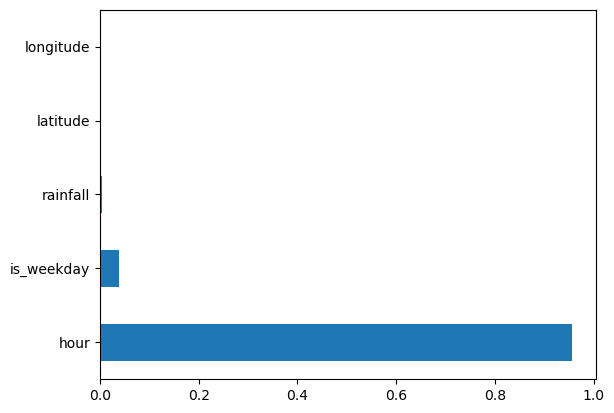

In [135]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [136]:
import sklearn.tree as tree


dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train, y_train.values.ravel())
y_test_pred = dtr.predict(X_test)

In [138]:
def get_carpark_availability(day, month, year, hour, minute, seconds, carpark):
    # Get nearest weather station from carpark
    nearest_weather_station = get_nearest_weather_station(carpark)
    # Get current time carpark's rainfall
    rainfall_site = f'https://api.data.gov.sg/v1/environment/rainfall?date_item={str(year)}-{str(month).zfill(2)}-{str(day).zfill(2)}'
    target_carpark = next(item for item in carparks if item['car_park_no'] == carpark)
    aggregate_rainfall = aggregate_rainfall_per_hour(month, year)
    try:
        print(f"Getting rainfall for {day}-{month}-{year}T{hour}:{minute}:{str(seconds).zfill(2)}")
        response_api = requests.get(rainfall_site)
        data = response_api.text
        data = json.loads(data)
        weather_station_readings = data['items'][0]['readings']
        target_weather_station = next(item for item in weather_station_readings if item['station_id'] == nearest_weather_station)
        target_aggregate_rainfall = aggregate_rainfall[str(year) + str(day).zfill(2) + str(hour-1).zfill(2)]
        target_aggregate_rainfall = target_aggregate_rainfall[target_weather_station['station_id']]
        input_data = {'latitude': [target_carpark['latitude']],
                      'longitude': [target_carpark['longitude']],
                      'hour': [hour],
                      'is_weekday': [get_is_weekday(day, month, year)],
                      'rainfall': [target_aggregate_rainfall]
                     }
        X = pd.DataFrame(input_data)
        return dtr.predict(X)
    except KeyError as e:
        print("KeyError", e)
        
carpark_availability = get_carpark_availability(12, 11, 2022, 10, 30, 0, 'ACB')
print(carpark_availability)

C:/Users/justi/OneDrive/Desktop/EE4211/project/Q3/112022_rainfall.csv
File exists, loading...
Getting rainfall for 12-11-2022T10:30:00
[0.64558319]


In [233]:
def sectorModels(longL, longR):
    df = final_nov_df[(final_nov_df['longitude'] > longL) & (final_nov_df['longitude'] > longR)]
    testDf = final_dec_df[(final_dec_df['longitude'] > longL) & (final_dec_df['longitude'] > longR)]

    X_train = df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
    y_train = df[['percentage_availability']]
    X_test = testDf[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
    y_test = testDf[['percentage_availability']]
    reg = ExtraTreesRegressor()
    reg.fit(X_train, y_train.values.ravel())
    y_test_pred = reg.predict(X_test)
    acc = reg_metrics(y_test, y_test_pred, X_train)
    return acc

In [234]:
# The longitude boundaries for west, central and east
# simplistic way fo splitting
westLong = (103.672, 103.768)
centralLong = (103.768, 103.858)
eastLong = (103.858, 103.960)
westAcc = sectorModels(westLong[0], westLong[1])
centralAcc = sectorModels(centralLong[0], centralLong[1])
eastAcc = sectorModels(eastLong[0], eastLong[1])

In [235]:
print(f"accuracy for west Sector is: {westAcc[0]}")
print(f"accuracy for central Sector is: {centralAcc[0]}")
print(f"accuracy for east Sector is: {eastAcc[0]}")

accuracy for west Sector is: 0.06462049274242403
accuracy for central Sector is: 0.06352849739026753
accuracy for east Sector is: 0.0584905830432861


In [225]:
one_carpark_nov_df = required_dec_df[required_dec_df['carpark_number'] == 'HLM']
one_carpark_nov_df = one_carpark_nov_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]

one_carpark_dec_df = required_dec_df[required_dec_df['carpark_number'] == 'HLM']
one_carpark_dec_df = one_carpark_dec_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall', 'percentage_availability']]


final_nov_df = one_carpark_nov_df.dropna()
final_dec_df = one_carpark_dec_df.dropna()




In [226]:
X_train = final_nov_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
y_train = final_nov_df[['percentage_availability']]
X_test = final_dec_df[['latitude', 'longitude', 'hour', 'is_weekday', 'rainfall']]
y_test = final_dec_df[['percentage_availability']]
reg = ExtraTreesRegressor()
reg.fit(X_train, y_train.values.ravel())
y_test_pred = reg.predict(X_test)
acc = reg_metrics(y_test, y_test_pred, X_train)
print(f"Accuracy for HLM: {acc[0]}")

Accuracy for HLM: 0.047225484723516314


## 3.2 Based on the insights derived from the analysis, suggest a practical action that can be taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as hyperparameter tuning here)

Some car parks with higher demand would have a greater chance of having vehicles idling while waiting for an available carpark lot. Idling can lead to unnecessary carbon emissions and we hope for our model to assist motorists in making the most informed decisions on the which car park they should go to. 

From our analysis, by checking if there are available carpark lots nearby using the function we provided, it can assist our country in lowering our carbon emissions and in turn, reduce the damage to our environment. 

We can also identify carparks that are highly affected by rainfall, and the authorities can use this information to take necessary actions to alleviate the situation (such as a potential conversion of a non-sheltered carpark to a sheltered one)

Furthermore, it was observed that our aggregated model from Q2 performed better than our non-aggregated model as the aggregated model has a lower RMSE at 0.03 as compared to the RMSE of 0.09 for the non-aggregated model. Since our non-aggregated model also has more features, it suggests that we should 'keep it simple' as much as possible.